In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import pyemu

In [3]:
import freyberg_setup
freyberg_setup.setup_pest_pp()
working_dir = freyberg_setup.WORKING_DIR_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_linearized_monte_carlo/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 


### First we need to run the calibration process to get the MAP parameters and last Jacobian

In [6]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 8
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.write(os.path.join(working_dir,pst_name))
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=10,master_dir='.')
os.chdir("..")

master:pestpp freyberg_pp.pst /h :4004 in .
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9


## Null-Space Monte Carlo with Freyberg Model

Adapted from the examples provided with `pyemu`


First create a linear analysis object.  We will use `MonteCarlo`  derived type, which allows us to use some sampling based methods.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.

In [20]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500)
gs = pyemu.geostats.GeoStruct(variograms=v)
cov = pyemu.helpers.pilotpoint_prior_builder(pst,{gs:[os.path.join(working_dir,"hkpp.dat.tpl")]},
                                            sigma_range=6)
mc = pyemu.MonteCarlo(jco=os.path.join(working_dir,pst_name.replace(".pst",".jcb")),parcov=cov)

In [18]:
mc.jco.df()

,rch_0,rch_1,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
flx_constan_19700102,-804.352169,0.000000e+00,-0.233046,0.716794,4.187772,1.387683,-0.116524,0.300135,3.667167,11.129746,...,3.817016,14.809032,19.342841,58.893619,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
flx_in-out_19700102,-2.499179,0.000000e+00,0.000000,-0.115696,-0.115696,-0.231391,0.000000,0.000000,0.343633,-0.115696,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
flx_percent_19700102,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
flx_recharg_19700102,12496.478171,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
flx_river_l_19700102,-11694.459996,0.000000e+00,0.282480,-0.677953,-4.124214,-1.468897,0.225985,-0.282480,-3.523836,-11.073250,...,516.939018,158.866942,154.290760,635.411271,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
flx_storage_19700102,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
flx_total_19700102,-2.485827,0.000000e+00,0.000000,-0.112992,-0.112992,-0.225984,0.000000,0.000000,0.335603,-0.112992,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
flx_wells_19700102,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-520.667758,-173.555919,-173.555919,-694.223678,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
flx_constan_19750101,-19.369324,-5.609088e+02,-0.162426,0.464327,2.754184,0.833316,-0.091806,0.187143,2.611414,7.452198,...,0.164192,0.556133,0.649705,0.764462,6.885458e-02,0.972792,6.410538e+00,16.731663,19.115091,8.925496e+01
flx_in-out_19750101,-0.226085,-3.390122e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.112927,-0.112927,0.000000,-0.112927,0.000000e+00,0.000000,0.000000e+00,0.112927,0.112927,0.000000e+00


In [21]:
pst.forecast_names

['fr03c16_19750102',
 'fr03c10_19750102',
 'fr04c9_19750102',
 'fr10c2_19750102',
 'fr14c11_19750102',
 'fr16c17_19750102',
 'fr22c11_19750102',
 'fr23c16_19750102',
 'fr25c5_19750102',
 'fr27c7_19750102',
 'fr30c16_19750102',
 'fr34c8_19750102',
 'fr35c11_19750102',
 'fr02c02_19750102',
 'fr01c13_19750102',
 'fr09c15_19750102',
 'fr25c10_19750102',
 'flx_river_l_19750102',
 'travel_time']

## null-space projection 

This is too easy.  Once you have drawn parameter realization, use the ```project_parensemble()``` method.  This method accepts 3 optional arguemnts: ``nsing``: number of singular components to demarcate the solution-null space boundary, ``par_file``: a pest .par file to use as the final parameter values, and ``inplace``, which is a boolean flag to control whether a new ```Ensemble``` instance should be created and returned.  The most important of these is ``nsing``.  If it is not passed, then ``nsing`` is set based on the ratio between the largest and smallest singular values >= 1.0e-6 

In [23]:
mc.draw(num_reals=1000,enforce_bounds=True)
unprojected50 = mc.parensemble.copy()
mc.project_parensemble(nsing=50,par_file=os.path.join(working_dir,pst_name.replace(".pst",".parb"))) 
projected50 = mc.parensemble.copy()

/Users/jwhite/Dev/python/pyemu/pyemu/en.py:668: UserWarning: deprecation warning: enforce_bounds should be either 'reset', 'drop', 'scale', or None, not bool...resetting to None.
  "...resetting to None.")


using 50 singular components


In [25]:
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
rch_1,rch_1,log,factor,1.0,0.75,1.25,rch,1.0,0.0,1
hk00,hk00,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1
hk01,hk01,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1
hk02,hk02,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1
hk03,hk03,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1
hk04,hk04,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1
hk05,hk05,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1
hk06,hk06,log,factor,5.0,0.50,50.00,hk,1.0,0.0,1


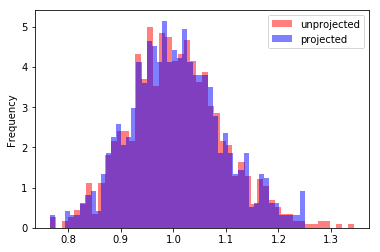

In [43]:
partoplot = 'w1_r29_c06'
ax = plt.subplot(111)
unprojected50.loc[:,partoplot].plot(kind="hist",bins=50,ax=ax,alpha=0.5,color='r',normed=True)
projected50.loc[:,partoplot].plot(kind="hist",bins=50,ax=ax,alpha=0.5,color='b',normed=True)
plt.legend(['unprojected','projected'])

We see that if we use a large number of singular components, then the null-space projection process greatly reduces the uncertainty in the ``rch_1`` parameter.  Note that using 50 singular components greatly overeastimates the dimension of the range space of the normal matrix ($\mathbf{J}^T\mathbf{Q}\mathbf{J}$) and is likely not justifiable, since only 12 observations are being used for inversion. Let's redo the redo the null-space projection operation with 12 singular components:

In [47]:
mc.draw(num_reals=1000,enforce_bounds=True)
unprojected12 = mc.parensemble.copy()
mc.project_parensemble(nsing=12,par_file=os.path.join(working_dir,pst_name.replace(".pst",".parb")))
projected12 = mc.parensemble.copy()

/Users/jwhite/Dev/python/pyemu/pyemu/en.py:668: UserWarning: deprecation warning: enforce_bounds should be either 'reset', 'drop', 'scale', or None, not bool...resetting to None.
  "...resetting to None.")


using 12 singular components


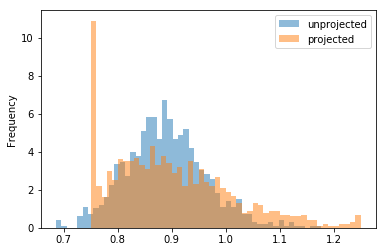

In [49]:
partoplot = 'rch_0'
ax = plt.subplot(111)
unprojected12.loc[:,partoplot].plot(kind="hist",bins=50,ax=ax,alpha=0.5, normed=True)
projected12.loc[:,partoplot].plot(kind="hist",bins=50,ax=ax,alpha=0.5, normed=True)
plt.legend(['unprojected','projected'])

Now we see that the null-space projection operation only slightly increases the kurtosis of the distribution

## How does this all pan out when we run the models?

Let's look at three options:  
1. unconstrained Monte Carlo (like we did before with just K and R)  
2. posterior sampling Null Space Monte Carlo 
3. posterior sampling Null Space Monte Carlo with a single iteration using existing Jacobian


### first, unconstrained

In [66]:
mc = pyemu.MonteCarlo(jco=os.path.join(working_dir,pst_name.replace(".pst",".jco")), parcov=cov)
mc.draw(num_reals=1000, enforce_bounds="reset",how='gaussian')
mc.parensemble.to_csv(os.path.join(working_dir,"sweep_in.unconst.csv"))
pst.pestpp_options["sweep_output_csv_file"] = "sweep_out.unconst.csv"
pst.pestpp_options["sweep_parameter_csv_file"] = "sweep_in.unconst.csv"
pst.write(os.path.join(working_dir,pst_name))

In [67]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.','sweep',pst_name,num_slaves=10,master_dir='.')
os.chdir("..")

master:sweep freyberg_pp.pst /h :4004 in .
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_9


### now with the constrained samples (from the posterior) with 12 singular values

In [68]:
mc.project_parensemble(nsing=12,par_file=os.path.join(working_dir,pst_name.replace(".pst",".parb")))
projected12 = mc.parensemble.copy()
projected12.to_csv(os.path.join(working_dir,"sweep_in.12sing.csv"))
pst.pestpp_options["sweep_parameter_csv_file"] = "sweep_in.12sing.csv"
pst.pestpp_options["sweep_output_csv_file"] = "sweep_out.12sing.csv"
pst.write(os.path.join(working_dir,pst_name))

using 12 singular components


In [69]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"sweep",pst_name,num_slaves=10,master_dir='.')
os.chdir("..")

master:sweep freyberg_pp.pst /h :4004 in .
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_9


### now with the ```schur``` bayesian monte carlo

In [70]:
sc = pyemu.Schur(jco=os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
sc.pst.parrep(os.path.join(working_dir,pst_name.replace(".pst",".parb")))
mc = pyemu.MonteCarlo(pst=pst,parcov=sc.posterior_parameter)
mc.draw(num_reals=1000, enforce_bounds="reset",how='gaussian')
mc.parensemble.to_csv(os.path.join(working_dir,"sweep_in.schur.csv"))
pst.pestpp_options["sweep_output_csv_file"] = "sweep_out.schur.csv"
pst.pestpp_options["sweep_parameter_csv_file"] = "sweep_in.schur.csv"
pst.write(os.path.join(working_dir,pst_name))
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"sweep",pst_name,num_slaves=10,master_dir='.')
os.chdir("..")

master:sweep freyberg_pp.pst /h :4004 in .
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_9


In [89]:
tags = ["schur","12sing","unconst"]
dfs = []
for tag in tags:
    df = pd.read_csv(os.path.join(working_dir,"sweep_out.{0}.csv".format(tag)))
    df.columns = [c.lower() for c in df.columns]
    dfs.append(df)


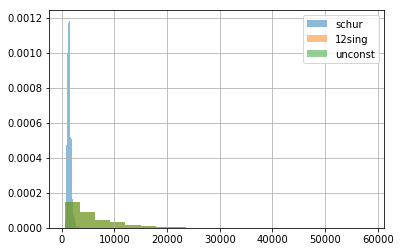

In [90]:
ax = plt.subplot(111)
for tag,df in zip(tags,dfs):
    df.phi.hist(ax=ax,bins=20,alpha=0.5,normed=True,label=tag)
#ax.set_xlim(0,2500)
plt.legend()
plt.show()

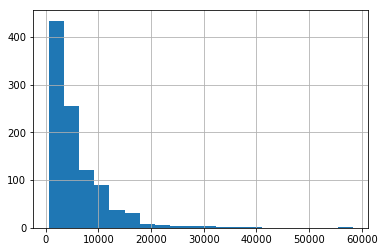

In [91]:
dfs[1].phi.hist(bins=20)
plt.show()

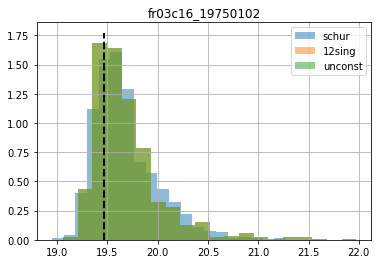

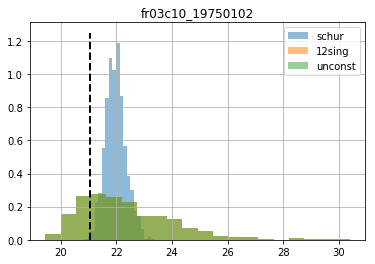

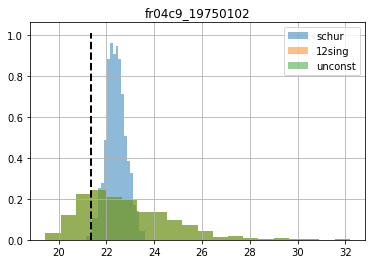

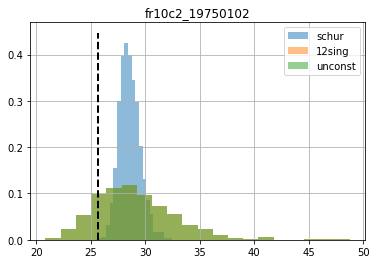

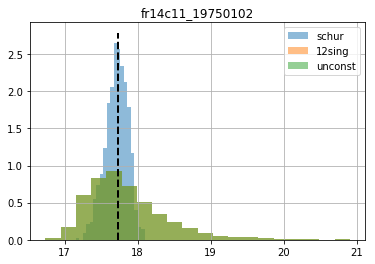

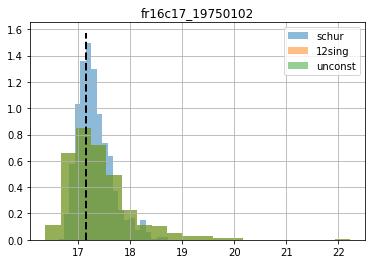

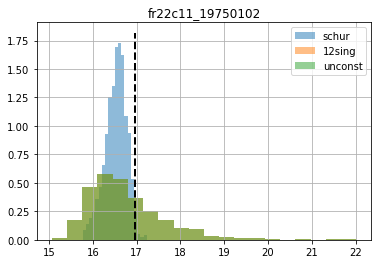

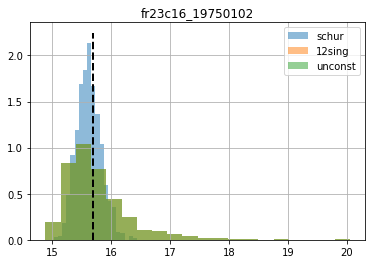

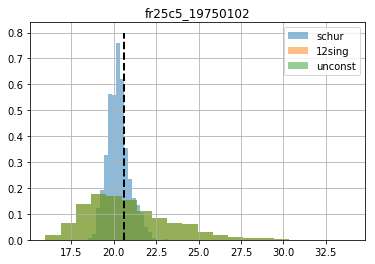

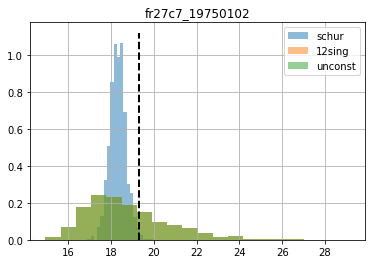

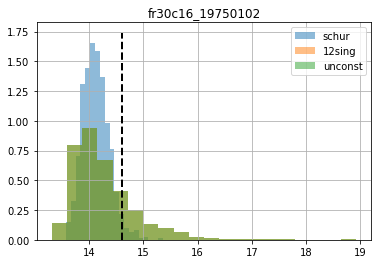

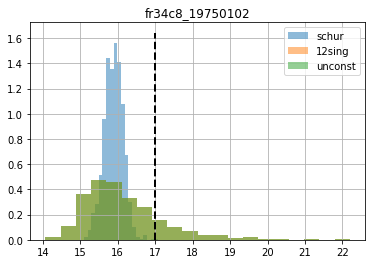

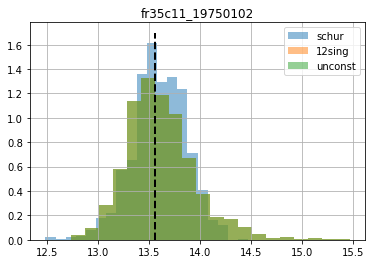

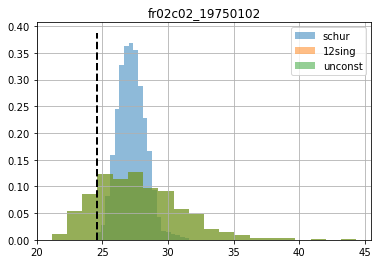

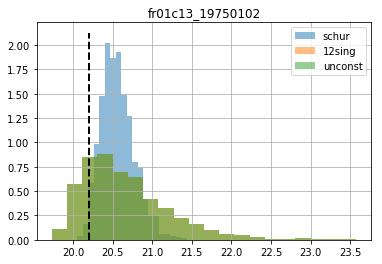

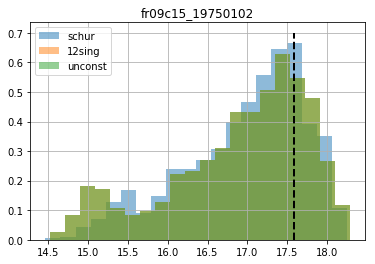

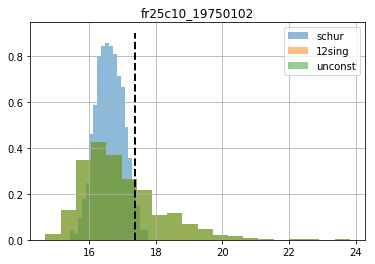

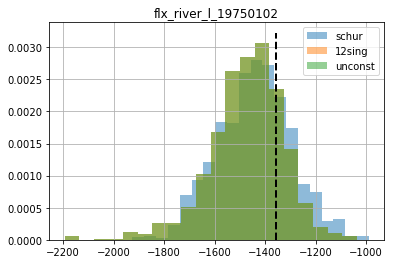

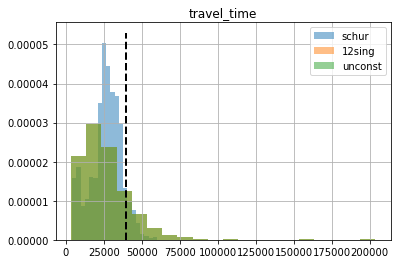

In [96]:
for forecast in mc.pst.forecast_names:
    ax = plt.subplot(111)
    for tag,df in zip(tags,dfs):
        #print(df.columns)
        df.loc[:,forecast].hist(ax=ax,bins=20,alpha=0.5,normed=True,label=tag)
    ylim = ax.get_ylim()
    v = mc.pst.observation_data.loc[forecast,"obsval"]
    ax.plot([v,v],ylim,"k--",lw=2.0)
    ax.set_title(forecast)
    ax.legend()
    plt.show()